## Importing Required Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

## Downloading the Dataset

In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = keras.utils.get_file(fname="stackoverflow", origin=url, untar=True, cache_dir=".", cache_subdir="")

6053168/6053168 [==============================] - 0s 0us/step


## Organizing Files in Train, Validation and Test Directories

In [3]:
train_dir = "./train"
test_dir = "./test"

In [4]:
validation_dir = "./validation"
os.mkdir(validation_dir)
validation_csharp_dir = os.path.join(validation_dir, "csharp")
os.mkdir(validation_csharp_dir)
validation_java_dir = os.path.join(validation_dir, "java")
os.mkdir(validation_java_dir)
validation_javascript_dir = os.path.join(validation_dir, "javascript")
os.mkdir(validation_javascript_dir)
validation_python_dir = os.path.join(validation_dir, "python")
os.mkdir(validation_python_dir)
files = [f"{i}.txt" for i in range(1000)]
for file in files:
  src = os.path.join(test_dir, "csharp", file)
  dst = os.path.join(validation_csharp_dir, file)
  shutil.move(src, dst)
for file in files:
  src = os.path.join(test_dir, "java", file)
  dst = os.path.join(validation_java_dir, file)
  shutil.move(src, dst)
for file in files:
  src = os.path.join(test_dir, "javascript", file)
  dst = os.path.join(validation_javascript_dir, file)
  shutil.move(src, dst)
for file in files:
  src = os.path.join(test_dir, "python", file)
  dst = os.path.join(validation_python_dir, file)
  shutil.move(src, dst)

In [5]:
!rm README.md stackoverflow.tar.gz

## Opening a Sample File

In [6]:
sample_file = os.path.join(test_dir, "javascript", "1564.txt")
with open(sample_file, mode="r+") as file:
  a = file.read()
a

'"using a variable from a blank function ok, i\'m fairly new to blank and am trying to make this script work. i don\'t know the terms of blank enough to search for this i guess because it seems like a fairly easy thing to do, but it is not working. the links are supposed to open a side menu that slides across the screen and displays different data depending on which link is clicked...my script: ./* open the sidenav */. function opennav(boxid) {.   document.getelementbyid(boxid).style.width = ""100%"";. }../* close/hide the sidenav */. function closenav() {.   document.getelementbyid(""mysidenav"").style.width = ""0"";. }...my body:   .    include(\'dbconn.php\');..    $sql = \'select * from joblist\';.    $result = $conn-&gt;query($sql);.    while ($row = $result-&gt;fetch_assoc()) {.        echo \'&lt;span onclick=""opennav(mysidenav-            \'.$row[\'jobname\'].\')""&gt;\'.$row[\'jobname\'].\'&lt;/span&gt;&lt;br&gt;\';.        echo \'&lt;div id=""mysidenav-\'.$row[\'jobname\'].\'

## Defining Class Names

In [7]:
class_names = np.array([item for item in os.listdir(train_dir)])
print(class_names)

['python' 'javascript' 'java' 'csharp']


## Defining Train, Validation and Test Datasets

In [8]:
train_dataset = tf.data.Dataset.list_files(f"{train_dir}/*/*")
validation_dataset = tf.data.Dataset.list_files(f"{validation_dir}/*/*")
test_dataset = tf.data.Dataset.list_files(f"{test_dir}/*/*")

## Defining Get Label Function

In [9]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return tf.cast(tf.argmax(parts[-2] == class_names), tf.int32)

In [10]:
get_label("/content/test/javascript/1001.txt")

<tf.Tensor: shape=(), dtype=int32, numpy=1>

## Defining Load Text Function

In [11]:
def load_text(file_path):
  text = tf.io.read_file(file_path)
  return text

## Defining Text Encoder

In [12]:
vocab_size = 5000

encoder = keras.layers.TextVectorization(max_tokens=vocab_size)
encoder.adapt(train_dataset.map(load_text))

## Defining Load Text with Label Function

In [13]:
def load_text_with_label(file_path):
  text = load_text(file_path)
  label = get_label(file_path)
  return text, label

## Defining Vectorize Text Function

In [14]:
def vectorize_text(text, label):
  return encoder(text), label

## Configuring the Dataset for Performance

In [15]:
train_dataset = train_dataset.map(load_text_with_label)
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(64)
validation_dataset = validation_dataset.map(load_text_with_label)
validation_dataset = validation_dataset.batch(64)
test_dataset = test_dataset.map(load_text_with_label)
test_dataset = test_dataset.batch(64)

In [16]:
vectorized_train_dataset = train_dataset.map(vectorize_text)
vectorized_validation_dataset = validation_dataset.map(vectorize_text)
vectorized_test_dataset = test_dataset.map(vectorize_text)

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
vectorized_train_dataset = vectorized_train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
vectorized_validation_dataset = vectorized_validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
vectorized_test_dataset = vectorized_test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Creating the Model

In [18]:
model = Sequential([layers.Embedding(vocab_size, 64),
                    layers.Dropout(0.2),
                    layers.GlobalAveragePooling1D(),
                    layers.Dropout(0.2),
                    layers.Dense(4)])

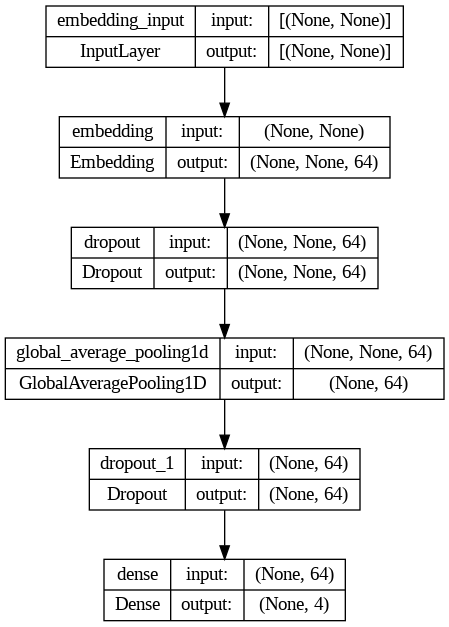

In [19]:
keras.utils.plot_model(model, show_shapes=True)

## Compiling the Model

In [20]:
model.compile(optimizer="adam",
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

## Fitting the Model

In [21]:
history = model.fit(vectorized_train_dataset, validation_data=vectorized_validation_dataset, epochs=50)

Epoch 1/50
125/125 [==============================] - 22s 158ms/step - loss: 1.3802 - accuracy: 0.3277 - val_loss: 1.3726 - val_accuracy: 0.4478
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 1.3602 - accuracy: 0.4186 - val_loss: 1.3484 - val_accuracy: 0.4745
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 1.3252 - accuracy: 0.4933 - val_loss: 1.3073 - val_accuracy: 0.5160
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 1.2742 - accuracy: 0.5451 - val_loss: 1.2509 - val_accuracy: 0.5602
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 1.2105 - accuracy: 0.6001 - val_loss: 1.1863 - val_accuracy: 0.6020
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 1.1420 - accuracy: 0.6379 - val_loss: 1.1223 - val_accuracy: 0.6450
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 1.0763 - accuracy: 0.6750 - val_loss: 1.0609 - val_accuracy: 0.6750
Epo

## Evaluating the Model

In [22]:
model.evaluate(vectorized_test_dataset)

63/63 [==============================] - 1s 9ms/step - loss: 0.5425 - accuracy: 0.8008


[0.5425222516059875, 0.8007500171661377]

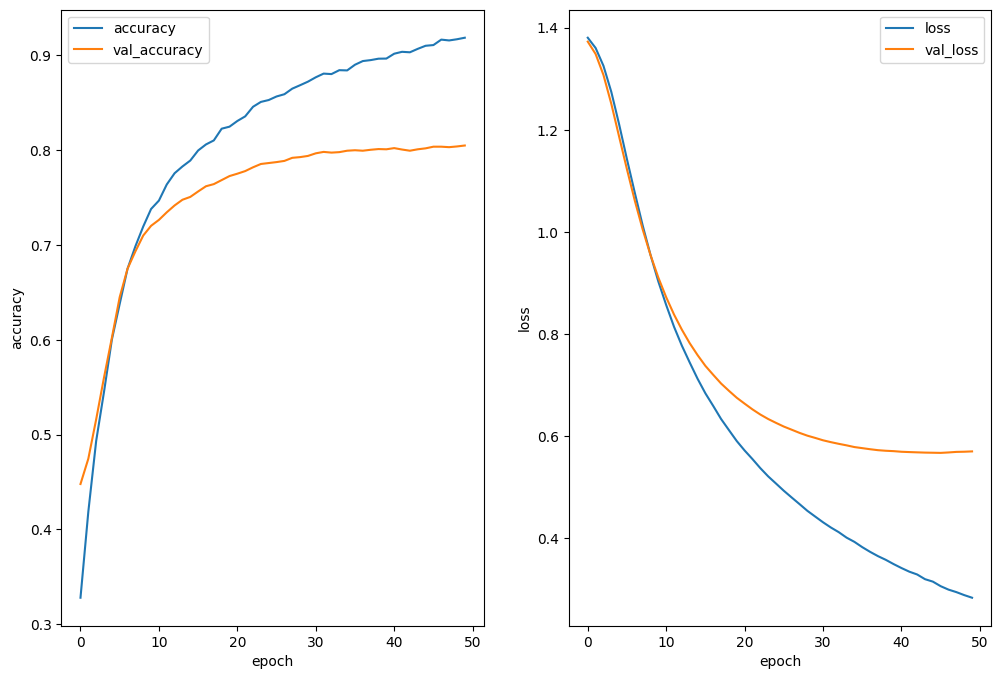

In [23]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()

In [26]:
export_model = Sequential([encoder,
                           model,
                           layers.Activation("softmax")])
export_model.compile(optimizer="adam",
                     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=["accuracy"])
export_model.evaluate(test_dataset)

63/63 [==============================] - 1s 10ms/step - loss: 0.5498 - accuracy: 0.8023


[0.5497909188270569, 0.8022500276565552]

In [27]:
classes = np.argmax(export_model.predict(["const array =",
                                          "def place_piece(board, x, y, player):",
                                          "void main(string[] args)",
                                          "private vector3 p_pos = new vector3(0, 0, 0);"],
                                         verbose=0), axis=-1)
predictions = [class_names[class_] for class_ in classes]
print(predictions)

['javascript', 'python', 'java', 'csharp']
